# TASK 3 
Szymon Forysiuk 23.03.2023

### LOADING LIBRARIES

In [220]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(1)
sns.set_style('whitegrid')

In [221]:
from keras.metrics import RootMeanSquaredError

from keras.models import Sequential
from keras.layers import Dense, Normalization
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras.losses import MeanSquaredError

from keras.optimizers import Adam

### LOADING internship_train.csv

In [222]:
internship_train = pd.read_csv('internship_train.csv')

internship_train.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,target
51466,244,439,144,126,144,240,-5.196152,0.218664,0,203,...,9.429973,9.273639,14.115146,9.260578,1.161663,6.102983,3.090071,12.139017,6.157536,27.218664
30175,158,153,48,230,33,52,-7.549834,0.429961,0,227,...,3.549915,7.233118,7.153687,0.284825,0.967409,14.428568,0.089058,6.958958,11.457305,57.429961
89034,224,37,217,206,184,348,-8.062258,0.846731,0,105,...,5.469969,0.636932,4.246468,7.702925,1.348000,3.238526,3.773742,6.413672,14.624216,65.846731
24929,198,124,324,368,159,411,-5.385165,0.641764,0,5,...,8.807561,14.123967,12.887896,8.037714,3.190350,4.563219,13.576401,10.510453,7.207442,29.641764
26512,199,155,306,375,290,2,9.899495,0.994446,1,3,...,9.900639,6.559701,4.527013,14.546323,8.795585,3.364328,7.238899,5.530187,9.660869,98.994446


###  EXPLORATORY DATA ANALYSIS

#### Basic informations for internship_train.csv

In [223]:
internship_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 54 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       90000 non-null  int64  
 1   1       90000 non-null  int64  
 2   2       90000 non-null  int64  
 3   3       90000 non-null  int64  
 4   4       90000 non-null  int64  
 5   5       90000 non-null  int64  
 6   6       90000 non-null  float64
 7   7       90000 non-null  float64
 8   8       90000 non-null  int64  
 9   9       90000 non-null  int64  
 10  10      90000 non-null  int64  
 11  11      90000 non-null  int64  
 12  12      90000 non-null  int64  
 13  13      90000 non-null  float64
 14  14      90000 non-null  float64
 15  15      90000 non-null  float64
 16  16      90000 non-null  float64
 17  17      90000 non-null  float64
 18  18      90000 non-null  float64
 19  19      90000 non-null  float64
 20  20      90000 non-null  float64
 21  21      90000 non-null  float64
 22

#### Looking for nan values

In [224]:
missing_percentages = internship_train.isnull().sum() * 100 / len(internship_train)

if any(missing_percentages != 0):
    print("There are columns with NaN values:")
    print(missing_percentages[missing_percentages != 0])
else:
    print("No columns have NaN values.")

No columns have NaN values.


####  internship_train's dtype of columns

In [225]:
print(internship_train.select_dtypes(exclude=['number']).columns)

Index([], dtype='object')


#### Correlation between internship_train's columns

<AxesSubplot:>

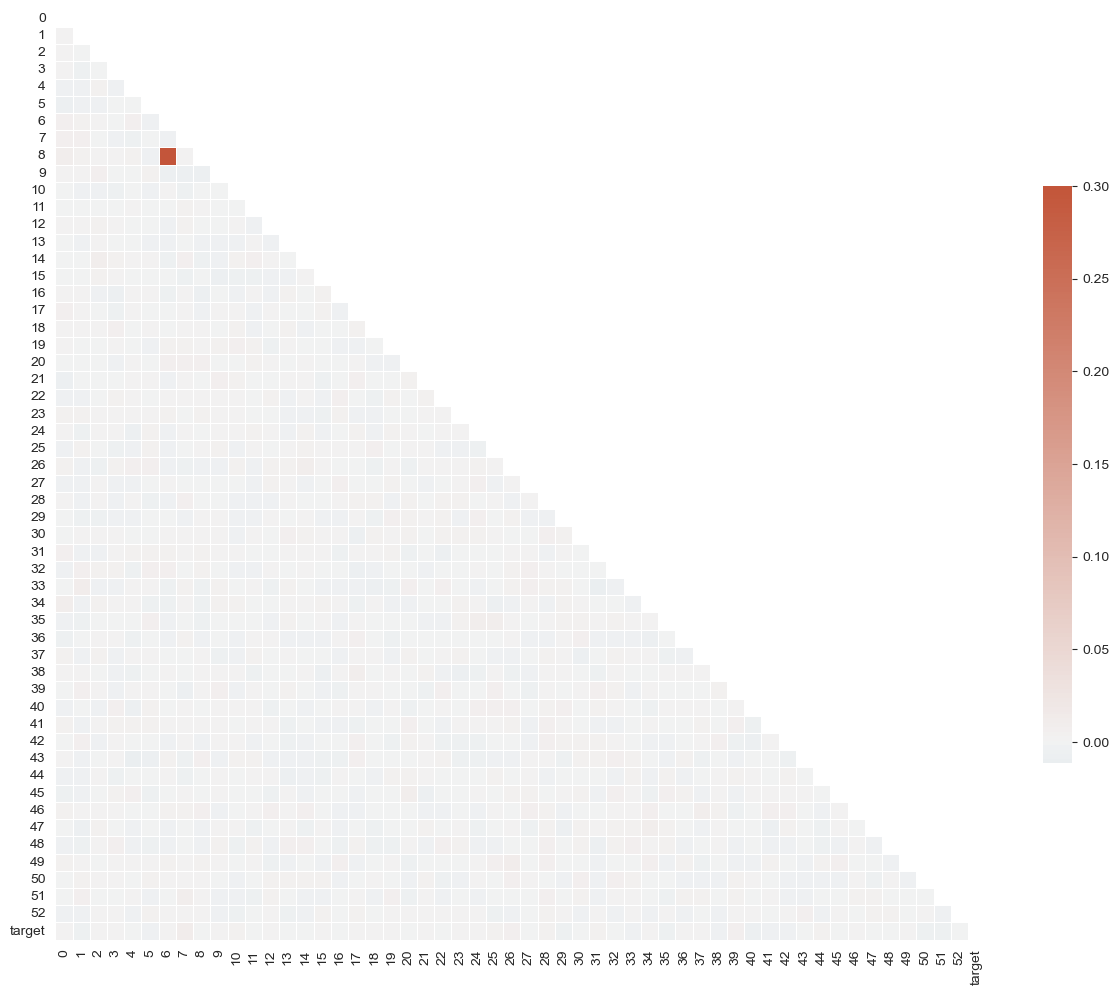

In [226]:
corr = internship_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(15,15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [227]:
print(internship_train['8'].corr(internship_train['6']))

0.9400156491340984


**Column 8 is correlated with column 6. Columns are correlated in over 94 procent. We have to drop one of them to reduce dimensionality!**

In [228]:
uncorrelated_internship_train = internship_train.drop('8', axis=1)

In [269]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = uncorrelated_internship_train.drop('target', axis=1), uncorrelated_internship_train['target']

standart_scaler = StandardScaler()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25,\
                                                  shuffle=True)

X_train_scaled =  standart_scaler.fit_transform(X_train)     
X_val_scaled = standart_scaler.transform(X_val)                                      

### XGBOOST REGRESSOR MODEL

In [270]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

**Hypertuning with RandomizedSearchCV on XGBRegressor**

In [271]:
param_grid = {'gamma': np.linspace(0.3,0.6,7),
              'learning_rate': np.linspace(0.05,0.3,6),
              'max_depth': [7,8,9],
              'n_estimators': np.arange(80,100,5),
              'reg_alpha': np.arange(0.7,0.9,0.05),
              'reg_lambda': np.arange(0.7,0.9,0.05)}

In [272]:
xgb_reg = xgb.XGBRegressor()

xgb_reg_randomizedCV = RandomizedSearchCV(estimator=xgb_reg, scoring='neg_mean_squared_error',\
                            param_distributions=param_grid, verbose=1, cv=5, n_iter=50)

xgb_reg_randomizedCV.fit(X_train_scaled, y_train.ravel())

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          predictor=None, random_state=None, ...),
                   n_ite

In [273]:
# Best params from
bp = xgb_reg_randomizedCV.best_params_
print(bp)

{'reg_lambda': 0.8, 'reg_alpha': 0.8, 'n_estimators': 85, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.6}


In [274]:
# Creating hypertuned XGBRegressor from xgb_reg_randomizedCV
final_xgb_reg = xgb_reg_randomizedCV.best_estimator_

In [275]:
from sklearn.metrics import mean_squared_error

print('root_mean_squared_error on train data: ',\
      mean_squared_error(y_train, final_xgb_reg.predict(X_train_scaled), squared=False))

print('root_mean_squared_error on validation data: ',\
      mean_squared_error(y_val, final_xgb_reg.predict(X_val_scaled), squared=False))

root_mean_squared_error on train data:  0.023425234441012865
root_mean_squared_error on validation data:  0.024451191136629063


In [277]:
# Dumping created xgb model 
import joblib
joblib.dump(final_xgb_reg, 'final_reg_pkl.pkl')

['final_reg_pkl.pkl']

In [ ]:
# Loading xgb model 
import pickle
final_xgb_reg = pickle.load(open('final_reg_pkl.pkl', "rb"))

### NEURAL NETWORK MODEL

In [198]:
input_shape = X_train_scaled.shape[1]

nn_reg = Sequential(name='nn_reg')
nn_reg.add(Dense(128, input_shape=[input_shape,], activation='relu', name='dense_128'))
nn_reg.add(Dense(32, activation='relu', name='dense_32'))
nn_reg.add(Dense(16, activation='relu', name='dense_16'))
nn_reg.add(Dense(8, activation='relu', name='dense_8'))
nn_reg.add(Dense(1, name='dense_1'))

In [199]:
nn_reg.summary()

Model: "nn_reg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_128 (Dense)           (None, 128)               6784      
                                                                 
 dense_32 (Dense)            (None, 32)                4128      
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 11,585
Trainable params: 11,585
Non-trainable params: 0
_________________________________________________________________


In [282]:
nn_reg.compile(loss=MeanSquaredError(), optimizer=Adam(),\
              metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [283]:
model_checkpoint = ModelCheckpoint(filepath='reg_task_3.h5', save_best_only = True, mode = 'min')
early_stopping = EarlyStopping(mode="min", patience=4)

nn_reg_fit = nn_reg.fit(X_train_scaled, y_train, batch_size=64, validation_split = 0.3,\
                     epochs=40, callbacks = [model_checkpoint, early_stopping])

Epoch 1/40
739/739 [==============================] - 1s 1ms/step - loss: 878.9583 - root_mean_squared_error: 29.6472 - mean_absolute_error: 24.2781 - val_loss: 137.8567 - val_root_mean_squared_error: 11.7412 - val_mean_absolute_error: 10.1665
Epoch 2/40
739/739 [==============================] - 1s 1ms/step - loss: 20.9605 - root_mean_squared_error: 4.5783 - mean_absolute_error: 3.4256 - val_loss: 9.4419 - val_root_mean_squared_error: 3.0728 - val_mean_absolute_error: 2.3762
Epoch 3/40
739/739 [==============================] - 1s 1ms/step - loss: 6.7159 - root_mean_squared_error: 2.5915 - mean_absolute_error: 2.0006 - val_loss: 4.8745 - val_root_mean_squared_error: 2.2078 - val_mean_absolute_error: 1.7082
Epoch 4/40
739/739 [==============================] - 1s 1ms/step - loss: 3.7658 - root_mean_squared_error: 1.9406 - mean_absolute_error: 1.5095 - val_loss: 2.8880 - val_root_mean_squared_error: 1.6994 - val_mean_absolute_error: 1.3291
Epoch 5/40
739/739 [===========================

In [192]:
# Dumping created nn_reg 
nn_reg.save("nn_reg")

INFO:tensorflow:Assets written to: nn_reg/assets


In [195]:
# Loading nn_reg
from keras.models import load_model
nn_reg = load_model("nn_reg")

In [284]:
nn_reg_df = pd.DataFrame(nn_reg_fit.history)
nn_reg_df['epoch'] = nn_reg_fit.epoch
nn_reg_df = nn_reg_df.set_index('epoch')
nn_reg_df.sample(10)

,loss,root_mean_squared_error,mean_absolute_error,val_loss,val_root_mean_squared_error,val_mean_absolute_error
epoch,,,,,,
24,0.375389,0.612690,0.456509,0.758929,0.871165,0.677530
25,0.409057,0.639576,0.482853,0.189933,0.435813,0.342861
21,0.390554,0.624943,0.472981,0.342140,0.584928,0.449811
14,0.680115,0.824691,0.617070,0.425517,0.652316,0.513299
2,6.715905,2.591506,2.000631,4.874456,2.207817,1.708155
17,0.478803,0.691956,0.531228,0.721114,0.849184,0.657654
8,0.977883,0.988880,0.775936,0.913939,0.956002,0.753351
3,3.765841,1.940578,1.509488,2.888028,1.699420,1.329071
11,0.698303,0.835645,0.654284,0.602013,0.775895,0.613546


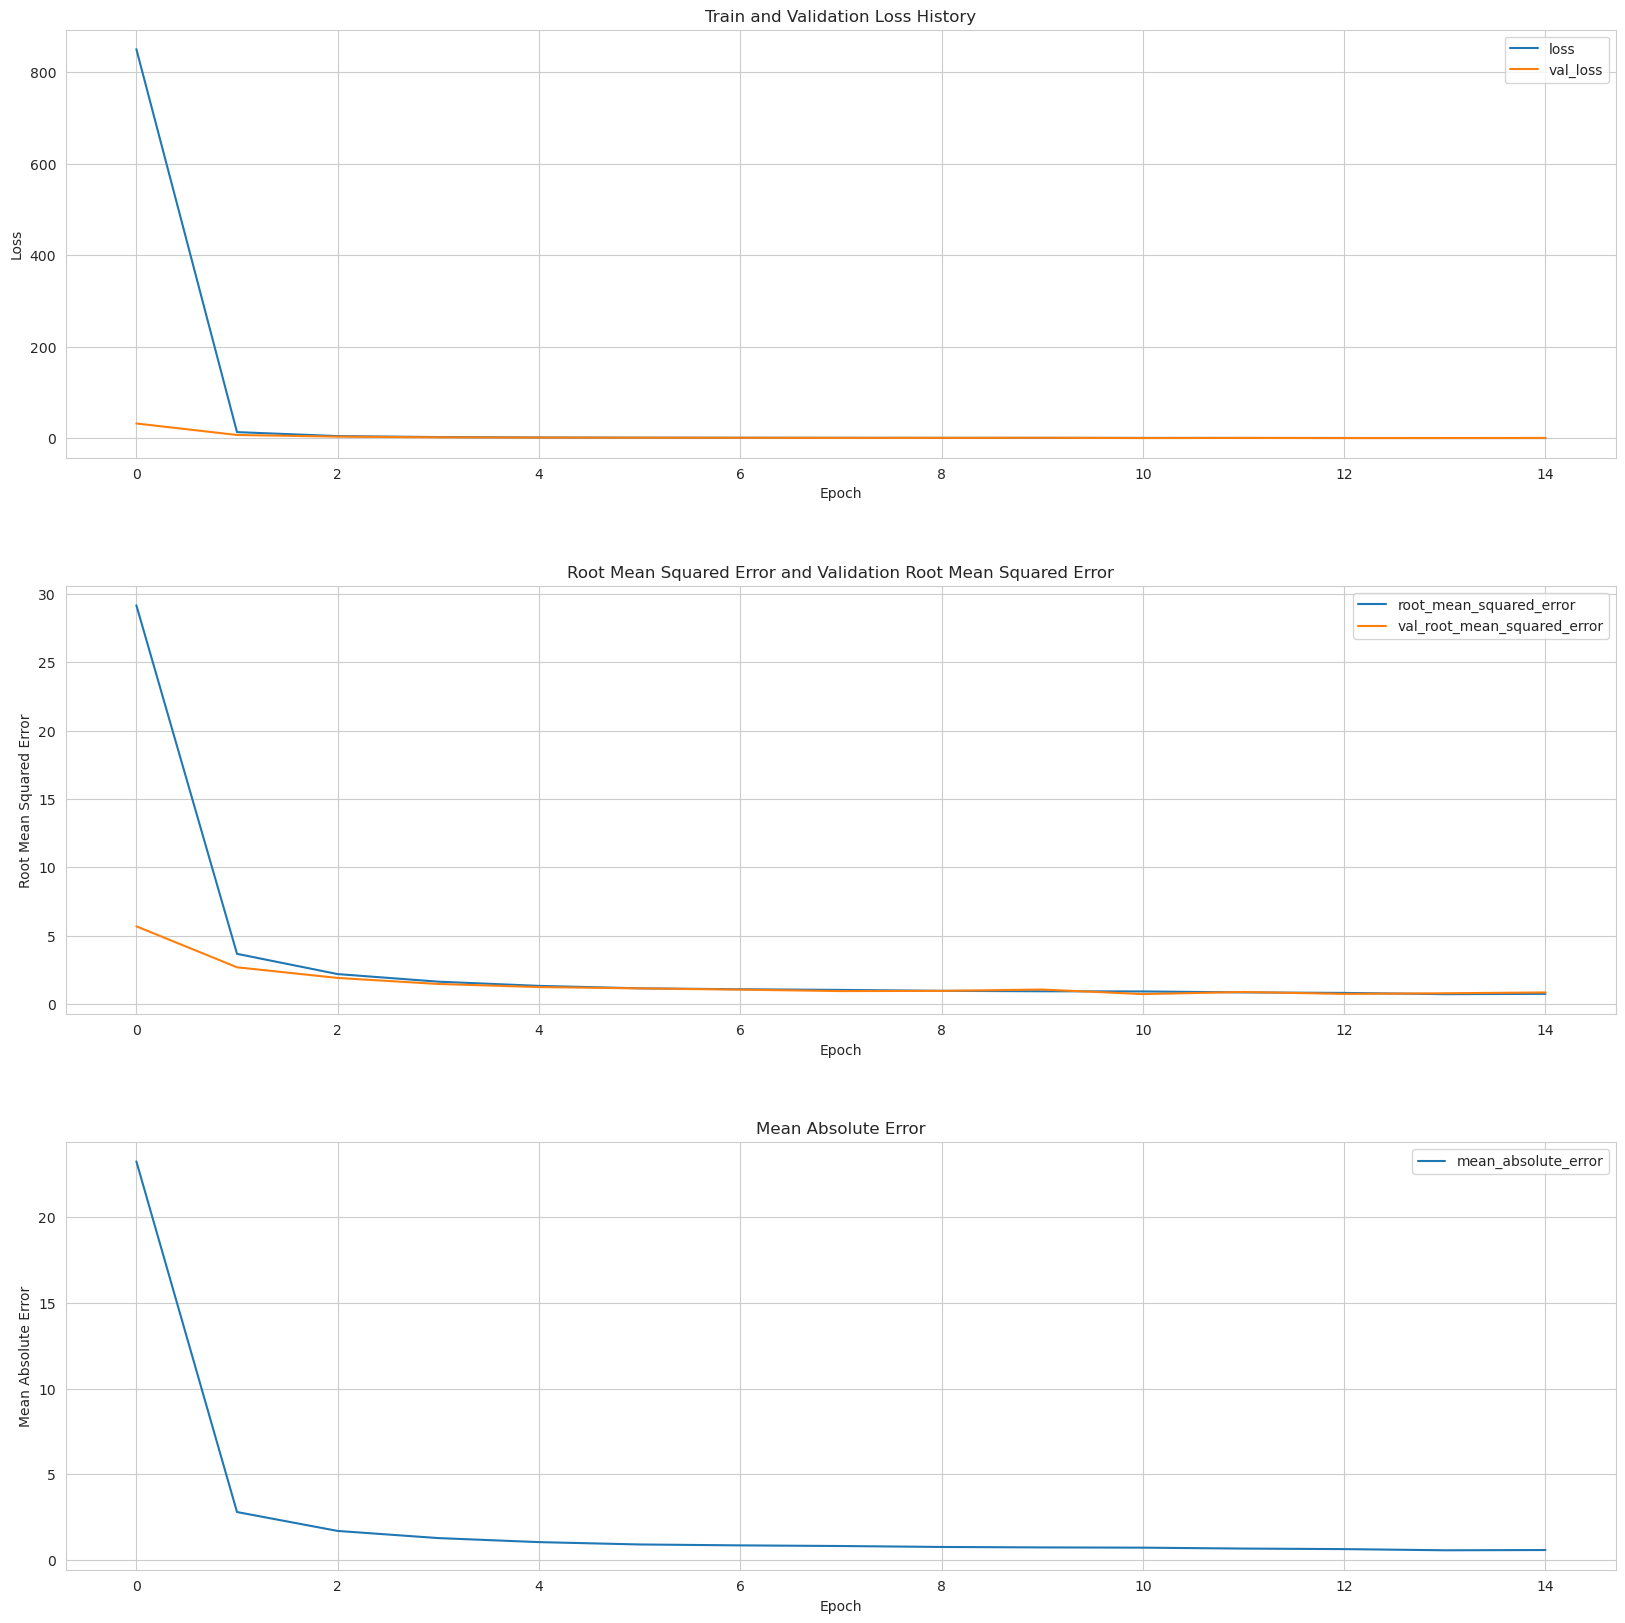

In [200]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,20))

# Plot 1 - train_loss_history and val_loss_history
sns.lineplot(data=nn_reg_df['loss'], ax=axes[0], label='loss')
sns.lineplot(data=nn_reg_df['val_loss'], ax=axes[0], label='val_loss')
axes[0].set_title('Train and Validation Loss History')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
plt.subplots_adjust(hspace = 0.3)

# Plot 2 - root_mean_squared_error and val_root_mean_squared_error
sns.lineplot(data=nn_reg_df['root_mean_squared_error'], ax=axes[1], label='root_mean_squared_error')
sns.lineplot(data=nn_reg_df['val_root_mean_squared_error'], ax=axes[1], label='val_root_mean_squared_error')
axes[1].set_title('Root Mean Squared Error and Validation Root Mean Squared Error')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Root Mean Squared Error')
plt.subplots_adjust(hspace = 0.3)

# Plot 3 - mean_absolute_error
sns.lineplot(data=nn_reg_df['mean_absolute_error'], ax=axes[2], label='mean_absolute_error')
axes[2].set_title('Mean Absolute Error')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Mean Absolute Error')
axes[2].legend()

plt.show()

In [286]:
print('root_mean_squared_error on train data: ',\
      mean_squared_error(y_train, nn_reg.predict(X_train_scaled), squared=False))

print('root_mean_squared_error on validation data: ',\
      mean_squared_error(y_val, nn_reg.predict(X_val_scaled), squared=False))

2110/2110 [==============================] - 1s 522us/step
root_mean_squared_error on train data:  0.4336803801099837
704/704 [==============================] - 0s 562us/step
root_mean_squared_error on validation data:  0.44179271591438396


### COMPARING MODELS

**Root Mean Squared Error Results for XGBRegressor**
- root_mean_squared_error on train data:  0.023425234441012865
- root_mean_squared_error on validation data:  0.024451191136629063

**Root Mean Squared Error Results for Neural Network**
- root_mean_squared_error on train data:  0.4336803801099837
- root_mean_squared_error on validation data:  0.44179271591438396

**XGBoost Regressor is definitely better than my custom neural network.**

### PPREDICTIONS ON internship_hidden_test.csv 

In [191]:
test = pd.read_csv('internship_hidden_test.csv')

,prediction
0,11.245076
1,78.709221
2,7.537620
3,37.498260
4,65.746796
5,37.456268
6,93.843147
7,98.427109
8,30.600554
9,26.266893


In [203]:
uncorrelated_test = test.drop('8', axis=1)
uncorrelated_test = standart_scaler.fit_transform(uncorrelated_test)

In [202]:
predictions = final_xgb_reg.predict(uncorrelated_test)

In [201]:
predictions_df = pd.DataFrame(predictions, columns = ['prediction'])

predictions_df.to_csv('predictions.csv')
predictions_df.head(10)

,prediction
0,11.245076
1,78.709221
2,7.537620
3,37.498260
4,65.746796
5,37.456268
6,93.843147
7,98.427109
8,30.600554
9,26.266893
